### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

# First Glance

In [3]:
data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
data.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


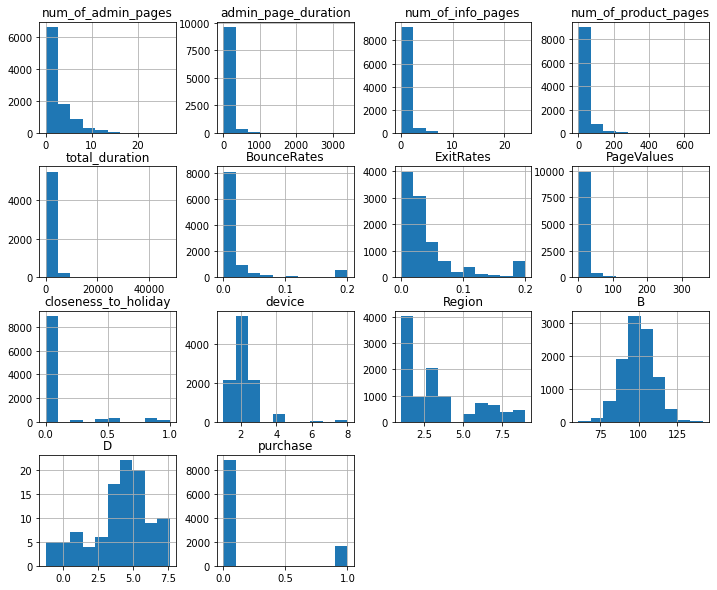

In [4]:
data.iloc[:,1:].hist(figsize=(12,10))
pass

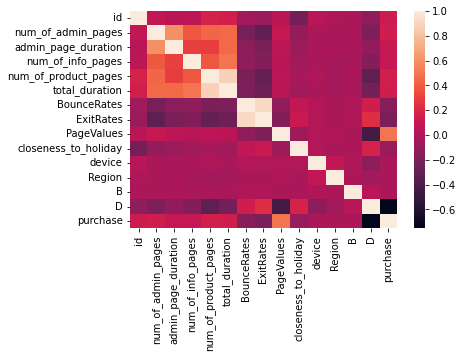

In [5]:
corr = data.corr()
sb.heatmap(corr)
pass

We can see from the heatmap that the durations are linked

# Exploration and Preprocessing  
Things we want to do:  
1. Split the data
2. Convert non-numeric features to numeric or dummies
3. Fill out missing values


## Splitting the data

In [6]:
Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.8,random_state=23)

print('y value couns:\n',y_train.value_counts(), sep='')
del X, Y
X_train.head(5)


y value couns:
0    1768
1     327
Name: purchase, dtype: int64


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
2442,2442,0.0,0.000000,0.0,0.0 minutes,5.0,108.0 minutes,108.000000,0.000000,0.080000,...,May,2.0,chrome_90.1.7,3.0,Returning_Visitor,False,c_13,92.047040,log202,NaN
4138,4138,7.0,188.166667,0.0,0.0 minutes,52.0,1089.642857 minutes,1277.809524,0.003509,0.010234,...,May,2.0,browser_5_v19,6.0,Returning_Visitor,True,c_5,95.347227,log8080,NaN
8935,8935,7.0,133.466667,4.0,46.5 minutes,26.0,1357.833333 minutes,NaN,0.000000,0.018487,...,Nov,3.0,chrome_89,9.0,New_Visitor,True,c_2,87.950930,log202,NaN
3648,3648,4.0,259.000000,1.0,42.0 minutes,18.0,401.968254 minutes,NaN,0.000000,0.017105,...,May,1.0,safari_14,3.0,Returning_Visitor,False,c_3,109.345812,log404,NaN
10110,10110,1.0,153.500000,0.0,0.0 minutes,NaN,1002.847222 minutes,NaN,0.000000,0.009524,...,Nov,2.0,chrome_90.1.7,4.0,Returning_Visitor,False,c_2,117.950076,log200,NaN


In [7]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

** types: **
id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

** label values: **
 0    1768
1     327
Name: purchase, dtype: int64
purchased sessions are around 15% of all sessions


## Exploring and Preprocessing Features 

### ID
We think that this feature is probelbly usless for us, so we decided to delete it.

In [8]:
def id_prep(X):
    X = X.drop(columns=['id'])
    return X

X_val = id_prep(X_val)
X_train = id_prep(X_train)
X_test = id_prep(X_test)


### page durations

In [9]:
## convert to numeric

def page_durations_prep(X):
    fields = ['info_page_duration', 'product_page_duration']
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

print('train:')
X_train = page_durations_prep(X_train)
print('validation:')
X_val = page_durations_prep(X_val)
print('test:')
X_test = page_durations_prep(X_test)

train:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  58
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  136
new types:
validation:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  259
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  485
new types:
test:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  64
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  113
new types:


In [10]:
## fill missing vlaues
avg_time_in_admin_page = (X_train.admin_page_duration / X_train.num_of_admin_pages).mean()
avg_time_in_info_page = (X_train.info_page_duration / X_train.num_of_info_pages).mean()
avg_time_in_product_page = (X_train.product_page_duration / X_train.num_of_product_pages).mean()

avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def page_durations_fill_na(X):
    
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(duration_fields):        
        num_of_field_copy = X[num_of_fields[i]].copy()
        num_of_field_copy = num_of_field_copy.fillna(num_of_field_copy.mean())
        X.loc[X[field].isna(), field] = avgs[i] * num_of_field_copy.loc[X[field].isna()]
    return X

X_train = page_durations_fill_na(X_train)
X_val = page_durations_fill_na(X_val)
X_test = page_durations_fill_na(X_test)

### total durations
On the one hand `total duration` has many nan values, on the other hand it is easy enough to calculate it. So we decided to keep it and fill the nans

In [11]:

def total_druation_data_prep(X):
    ## total duration
    computed_durations = X.admin_page_duration + X.info_page_duration + X.product_page_duration
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

X_train = total_druation_data_prep(X_train)
X_val = total_druation_data_prep(X_val)
X_test = total_druation_data_prep(X_test)

In [12]:
X_train.info_page_duration.loc[X_train.info_page_duration.isnull()]

Series([], Name: info_page_duration, dtype: float64)

### num of page visits

In [13]:
# fill missing values
avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def num_of_visits_data_prep(X: pd.DataFrame):
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(num_of_fields):
        X.loc[X[field].isna(), field] = [ int(value / avgs[i]) for value in X.loc[X[field].isna(), duration_fields[i]]]
    return X


X_train = num_of_visits_data_prep(X_train)
X_val = num_of_visits_data_prep(X_val)
X_test = num_of_visits_data_prep(X_test)

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [14]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('`Returning_Visitor` categoryh is ', f"{round(vc['Returning_Visitor'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')

original user type values:
 Returning_Visitor    1781
New_Visitor           290
Other                  17
Name: user_type, dtype: int64
nan count        : 7

`other` categoryh is only  0.81% of the data
`Returning_Visitor` categoryh is  85.01% of the data
nan values are only  0.33% of the data


explore correlations betwenn user type and other features

In [15]:
X_train_user_dummy = pd.get_dummies(X_train,columns=['user_type'], prefix_sep='_dmy_', drop_first=False)

<AxesSubplot:>

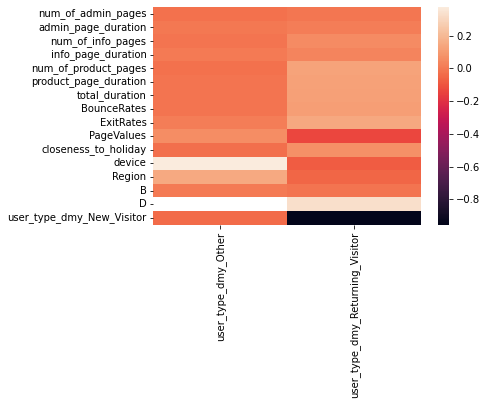

In [16]:
sb.heatmap(X_train_user_dummy.corr()[16:19].T[:16])

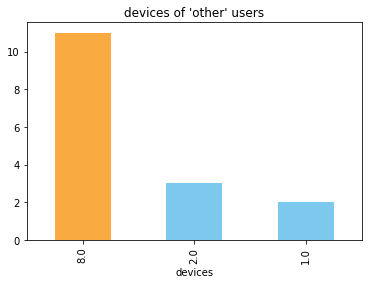

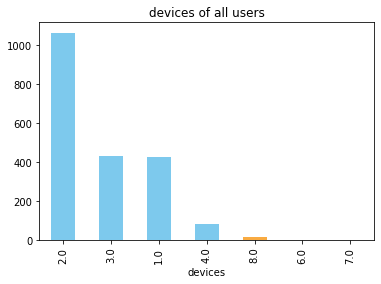

In [17]:
X_train.loc[X_train.user_type == 'Other', ('device')].value_counts().plot.bar(color=['#F9AB42']+['#7DC9ED']*2,
 title="devices of 'other' users", xlabel='devices')
plt.show()
devices_all = X_train.device.value_counts()
i = np.where(devices_all.index == 8.0)[0][0]
clrs = ['#7DC9ED']*7
clrs[i] = "#F9AB42"
devices_all.plot.bar(color=clrs,
 title="devices of all users", xlabel='devices')
plt.show()

### user_type - conclusion
two interesting correlartion here:  
a. `device` and `Other`:   
altough device 8 is very rare, almost all of device 8 sessions are `other`.  
It may mean that device 8 has some bug when collecing `user_type` data. However for our purpose it is not helpful (We were looking for a way to turn "other" to one of the other two.)  
b. `D`. but since `D` is mostly missing values, We shall treat `user type` as binary: only new users (0) and returing users (1)

In [18]:
#  map 'Returning_Visitor' , missing value and  'other' to 1, and New_Visitor to 0

def user_type_data_prep(X):
    RETURNING ='Returning_Visitor'
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

X_train = user_type_data_prep(X_train)
X_val = user_type_data_prep(X_val)
X_test = user_type_data_prep(X_test)

### D feature
D's seem to have mostly nan values.  
If it's lower than 10%, we will remove it altogether.

In [19]:
valid_ds = X_train.loc[~np.isnan(X_train.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

def d_data_prep(X):
    # remove D feature        
    return X.drop(columns=('D'))
del valid_ds

X_train = d_data_prep(X_train)
X_val = d_data_prep(X_val)
X_test = d_data_prep(X_test)

only 0.9 % of D's have values


### Bounce rate,  Exit rate, Page value

In [20]:
print('BounceRates nan count:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count:', X_train.ExitRates.isnull().sum())
print('page values nan count:', X_train.PageValues.isnull().sum())

def rates_page_value_data_prep(X):    
    # so little nan values - lets fill with mean
    X.BounceRates = X.BounceRates.fillna(X_train.BounceRates.mean())
    X.ExitRates = X.ExitRates.fillna(X_train.ExitRates.mean())
    X.PageValues = X.PageValues.fillna(X_train.PageValues.mean())
    return X


X_train = rates_page_value_data_prep(X_train)
X_val= rates_page_value_data_prep(X_val)
X_test = rates_page_value_data_prep(X_test)

BounceRates nan count: 5
ExitRates nan count: 3
page values nan count: 6


In [21]:
print('BounceRates nan count after filling:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count after filling:', X_train.ExitRates.isnull().sum())
print('page values nan count after filling:', X_train.PageValues.isnull().sum())

## לא יודעת אם צריך את זה

BounceRates nan count after filling: 0
ExitRates nan count after filling: 0
page values nan count after filling: 0


### closeness to holiday

In [22]:
print('closeness_to_holiday nan caount:', X_train.closeness_to_holiday.isnull().sum())


closeness_to_holiday nan caount: 85


To fill the null values, we will try to find any correlataions between this feature and the others.

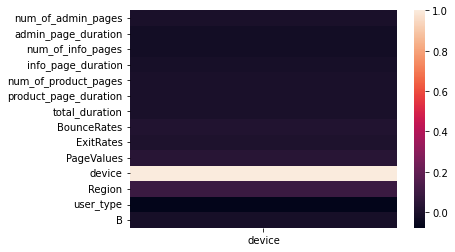

In [23]:
corr = X_train.corr()
sb.heatmap(corr.iloc[11:12].T[corr.columns != 'closeness_to_holiday'])
pass

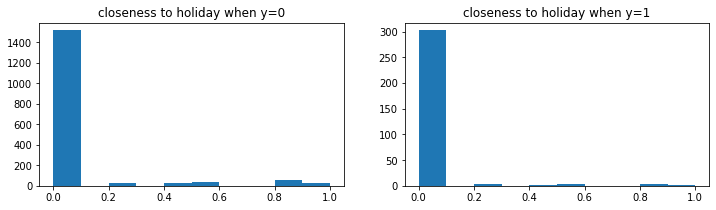

In [24]:
figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[y_train ==yi])
    axe.set_title(f'closeness to holiday when y={yi}')
plt.show()

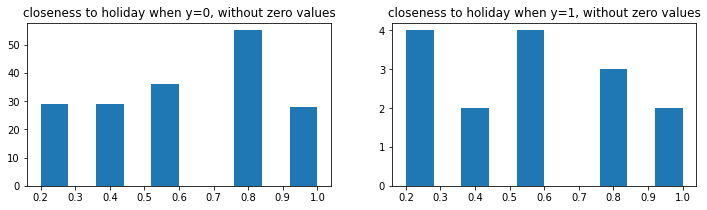

In [25]:
figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[(y_train ==yi) & X_train.closeness_to_holiday != 0.0])
    axe.set_title(f'closeness to holiday when y={yi}, without zero values')
plt.show()

We didn't found any intersting correlataions between this feature and others. So we will use its mean to fill the null values.

In [26]:
def closeness_data_prep(X):    
    X.closeness_to_holiday = X.closeness_to_holiday.fillna(X_train.closeness_to_holiday.mean())
    return X

X_train = closeness_data_prep(X_train)
X_val = closeness_data_prep(X_val)
X_test = closeness_data_prep(X_test)


### Device

In [27]:
X_train.device.value_counts()


2.0    1063
3.0     432
1.0     424
4.0      84
8.0      14
6.0       2
7.0       1
Name: device, dtype: int64

In [28]:
def make_dummy_device(X: pd.DataFrame):
    mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False, prefix_sep='_dmy_')
    
X_train = make_dummy_device(X_train)
X_val = make_dummy_device(X_val)
X_test = make_dummy_device(X_test)


In [29]:
X_train.columns

Index(['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'total_duration', 'BounceRates', 'ExitRates', 'PageValues',
       'closeness_to_holiday', 'Month', 'internet_browser', 'Region',
       'user_type', 'Weekend', 'A', 'B', 'C', 'device_dmy_1', 'device_dmy_2',
       'device_dmy_3', 'device_dmy_other'],
      dtype='object')

### C feature

In [30]:
X_train.C.value_counts()

log200     378
log404     363
log_100    357
log202     341
log8080    332
log400     320
Name: C, dtype: int64

In [31]:
def make_dummy_C(X: pd.DataFrame):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False, prefix_sep='_dmy_')
    

X_train = make_dummy_C(X_train)
X_val = make_dummy_C(X_val)
X_test = make_dummy_C(X_test)


### weekend

In [32]:
X_train.Weekend.value_counts()

False    1588
True      502
Name: Weekend, dtype: int64

In [33]:
def weekend_data_prep(X):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

X_train = weekend_data_prep(X_train)
X_val = weekend_data_prep(X_val)
X_test = weekend_data_prep(X_test)

X_train.Weekend.value_counts()

0    1588
1     507
Name: Weekend, dtype: int64

## B feature

In [34]:
print("B nan count:", X_train.B.isnull().sum())
def b_data_prep(X):
    global X_train
    X.B = X.B.fillna(X_train.B.mean())
    return X

X_train = b_data_prep(X_train)
X_val = b_data_prep(X_val)
X_test = b_data_prep(X_test)

print("B nan count after filling - train:", X_train.B.isnull().sum())
print("B nan count after filling - validation:", X_val.B.isnull().sum())

B nan count: 6
B nan count after filling - train: 0
B nan count after filling - validation: 0


## browser

In [35]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

X_val.internet_browser = X_val.internet_browser.str.replace('\d+', '')
X_val['internet_browser'] = X_val['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

print(X_train.internet_browser.value_counts())

# corr = X_train.corr()
# sb.heatmap(corr.iloc[8:15].T[corr.columns != 'internet_browser'])


# X_train.internet_browser = ['Other' if i == 'nan' else X_train.internet_browser]

chrome     1286
safari      380
browser     192
nan         123
edge        114
Name: internet_browser, dtype: int64


In [36]:
X_train_browser_dummy = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')

### fill na - browser
To fill the nan values of browser, lets try to find any correlations to understand more about it.  

<AxesSubplot:>

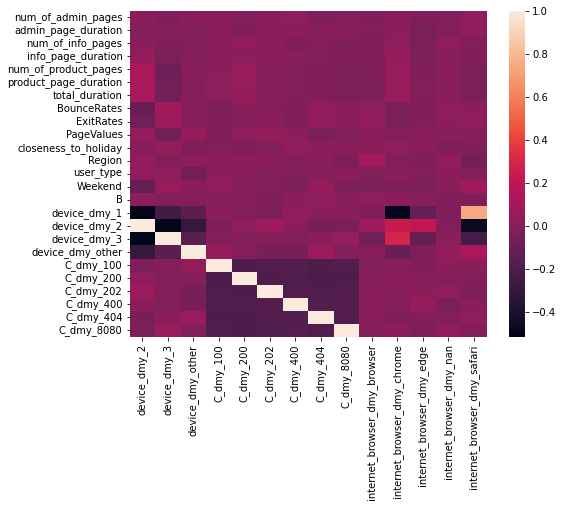

In [37]:
corr = X_train_browser_dummy.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr.iloc[16:].T[~corr.columns.str.startswith('internet_browser')])

We can see that there's a link between device and browswer:  
Device 1 is linked to safari (could be iPhone or mac), devices 2 & 3 are linked to chrome.  
So we are going to fill the nan values according to the device.  
An observation with device 1 - will be filled with safari, and observation with device 2 or 3 will be filled with chrome.  
Because chome is the most common browser in our data - all the observation with device other - will be filled with chorme as well.

In [38]:
def browser_data_prep(X: pd.DataFrame):    
    X.internet_browser = X.internet_browser.str.replace('\d+', '')
    X['internet_browser'] = X['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')    
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')    

    # device 1 means safari
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_1 > 0), ('internet_browser_dmy_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_2 + X.device_dmy_3  > 0), ('internet_browser_dmy_chrome',)] = 1

    print(X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1), 'internet_browser_dmy_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_dmy_nan == 1) & ((X.internet_browser_dmy_chrome + X.internet_browser_dmy_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_dmy_nan'])

X_train = browser_data_prep(X_train)
X_val = browser_data_prep(X_val)
X_test = browser_data_prep(X_test)

16  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.
42  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.
9  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.


## month
We decided to divide the year to 4 yearly quarters.  
Which means:  
Jan-Mar: quarter 1  
Apr-June: quarter 2  
Jul-Sep: quarter 3  
Oct-Dec: quarter 4

In [39]:
def month_data_prep(X):
     Month_map = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
     X.Month = X.Month.map(Month_map)
     X.Month = X.Month.fillna(X_train.Month.median())
     return X

X_train = month_data_prep(X_train)
X_val = month_data_prep(X_val)
X_test = month_data_prep(X_test)


X_train.Month.value_counts()

4.0    895
2.0    621
1.0    338
3.0    241
Name: Month, dtype: int64

## Region

In [40]:
print(X_train.Region.value_counts())
print('nan count before filling:', X_train.Region.isnull().sum())

# fill nan with median
def region_data_prep(X: pd.DataFrame):
    global X_train
    train_median = np.median(X_train.Region[~X_train.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X


X_train = region_data_prep(X_train)
X_val = region_data_prep(X_val)
X_test = region_data_prep(X_test)



print('nan count after filling:', X_train.Region.isnull().sum())

1.0    795
3.0    398
2.0    205
4.0    189
7.0    155
6.0    131
9.0     96
8.0     76
5.0     48
Name: Region, dtype: int64
nan count before filling: 2
nan count after filling: 0


## A feature

In [41]:
t1 = X_train.A[[str(a).split('_').__len__() == 2 for a in X_train.A]]
t2 = X_train.A[[str(a).split('_').__len__() > 2 for a in X_train.A]]
print('type 1:',t1.iloc[0:5])
print('count', t1.shape[0])

print('\ntype 2:\n', t2.iloc[0:5])
print('count', t2.shape[0])

type 1: 2442     c_13
4138      c_5
8935      c_2
3648      c_3
10110     c_2
Name: A, dtype: object
count 1915

type 2:
 3969    c_20_74
4926    c_20_14
4351    c_20_61
5329    c_20_47
5213     c_20_4
Name: A, dtype: object
count 34


In [42]:
print('type 1 describe:')
pd.Series([float(str(a).split('_')[1]) if str(a).split('_').__len__() == 2 else np.nan for a in X_train.A]).describe()

type 1 describe:


count    1915.000000
mean        3.800522
std         3.485887
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
dtype: float64

since max is now 19, seems reasonble to use the `c_xx_??` type as `xx`  
this way we can transfer all using `.split('_')[1]`

<AxesSubplot:>

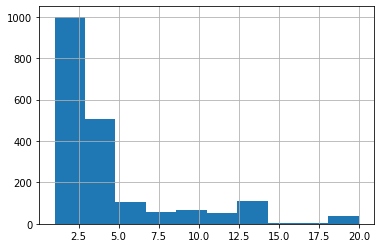

In [43]:
X_train.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_train.A]
X_val.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_val.A]
X_test.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_test.A]


X_train.A.hist()

In [44]:
print('nan count:', X_train.A.isna().sum())

nan count: 146


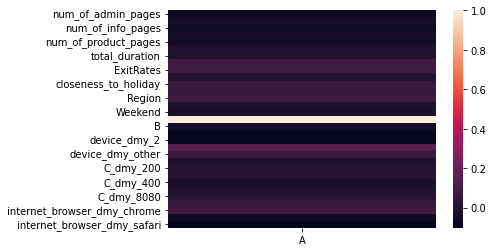

In [45]:
corr = X_train.corr()
sb.heatmap(corr[corr.columns == 'A'].T)
pass

Since the distribution decreases left to rihgt - we will fill all nan values with median.

nan count after filling - train: 0
nan count after filling - validation: 0


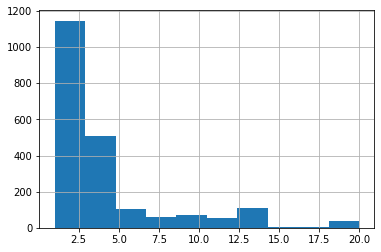

In [46]:
def a_data_prep(X, X_t):
    train_median = np.median(X_t.A[~X_t.A.isnull()])
    X.A = X.A.fillna(train_median)
    #X.A[X.A.isnull()] = train_median
    return X

X_train = a_data_prep(X_train, X_train)
X_val = a_data_prep(X_val, X_train)
X_test = a_data_prep(X_test, X_train)

X_train.A.hist()

print('nan count after filling - train:', X_train.A.isnull().sum())
print('nan count after filling - validation:', X_val.A.isnull().sum())

In [47]:
X_val.A

8599      2.0
4646     13.0
5836      5.0
2476      6.0
8509     13.0
         ... 
8127      2.0
5478      3.0
5310     13.0
2254      1.0
10429     7.0
Name: A, Length: 8384, dtype: float64

# Outlier removal and normalization

Because min max normalization function is sensative to ourliers, we will have to take care of them before using it.

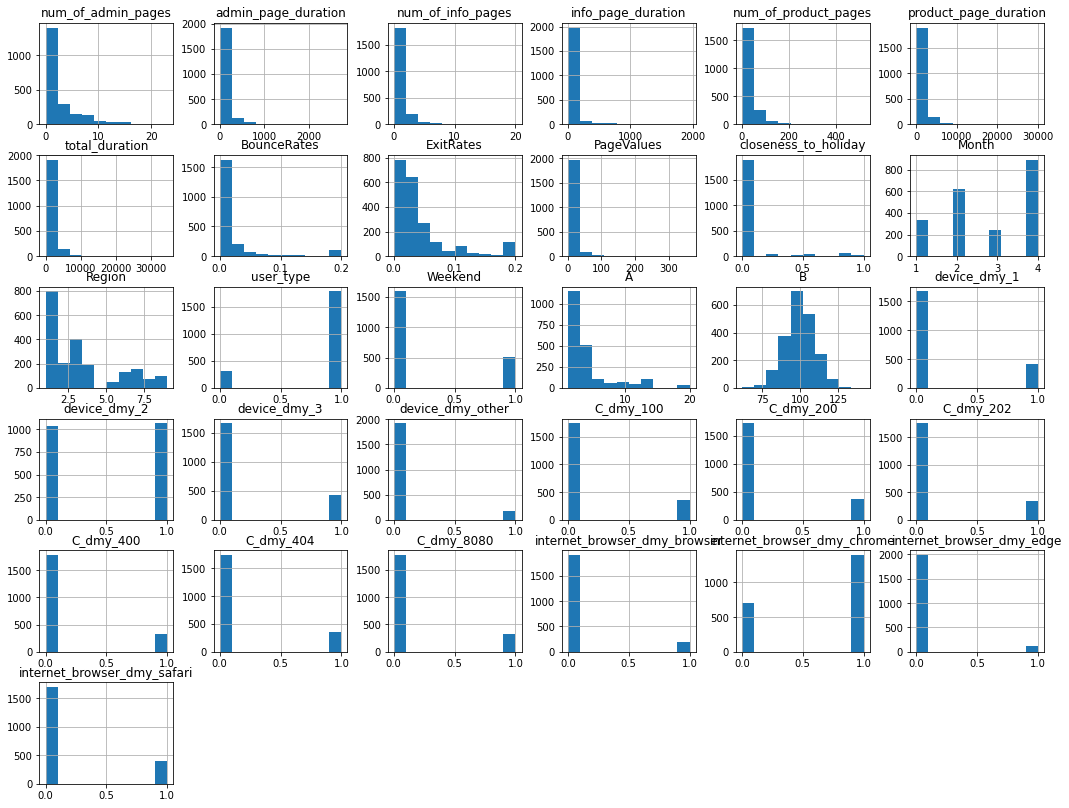

In [48]:
X_train.hist(figsize=(18,14))
pass
## some try

B looks very much like normal distribution. We will use it

Text(0.5, 1.0, 'Check Outliers After Treatment')

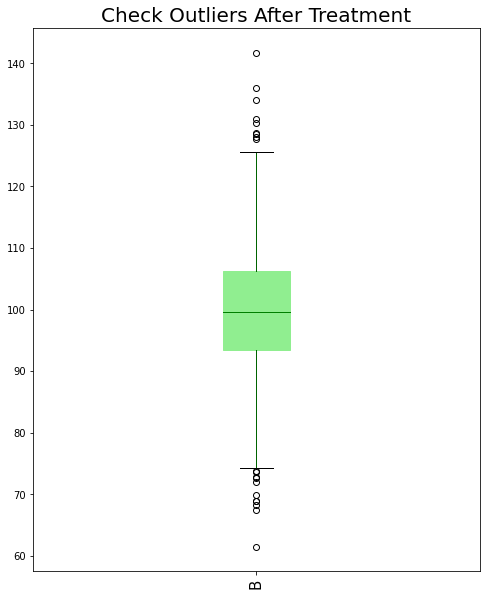

In [49]:
B_cloumn= pd.DataFrame(X_train.B)
props = dict(boxes="lightgreen", whiskers="darkgreen", medians="Green", caps="black")
plt_box = B_cloumn.plot.box(color=props, patch_artist=True,figsize=(8,10))
plt.xticks(rotation = 'vertical',size = 15)
plt_box.set_title('Check Outliers After Treatment',size = 20)

In [50]:
X_train.B.var()

98.67363157091866

we tried to find outliers by looking at the values of the relevant fields  

In [51]:
#fields = ['num_of_admin_pages' , 'admin_page_duration' , 'num_of_info_pages' , 'info_page_duration' , 'num_of_product_pages' , 'product_page_duration'
#, 'total_duration' , 'BounceRates' , 'ExitRates' , 'PageValues' , 'closeness_to_holiday' , 'A' ]

"""
for field in fields:
    p = X_train[field].quantile(q=0.05)
    print(field, ':\n', X_train[field].value_counts().loc[lambda x : x < p ])
"""

fields = ['admin_page_duration' , 'info_page_duration' , 'product_page_duration' , 'total_duration' , 
'BounceRates' , 'ExitRates' , 'PageValues' , 'closeness_to_holiday' , 'A' ]

for field in fields:
    print(field, ':\n', X_train[field].value_counts().sort_index(ascending=False))


admin_page_duration :
 2720.500000      1
2657.318056      1
2156.166667      1
1566.600000      1
1535.355556      1
              ... 
4.000000        12
3.500000         1
3.000000         3
2.000000         4
0.000000       995
Name: admin_page_duration, Length: 804, dtype: int64
info_page_duration :
 1949.166667       1
1779.166667       1
1778.000000       1
1767.666667       1
1475.250000       1
               ... 
5.000000          3
4.000000          1
3.000000          3
2.000000          1
0.000000       1673
Name: info_page_duration, Length: 322, dtype: int64
product_page_duration :
 29970.46597      1
27009.85943      1
23888.81000      1
18171.79454      1
17550.58486      1
              ... 
5.00000          1
4.00000          4
3.00000          1
1.00000          1
0.00000        110
Name: product_page_duration, Length: 1792, dtype: int64
total_duration :
 34576.950690      1
28450.201100      1
25390.010000      1
20398.108830      1
17782.938431      1
             

In [52]:
print('admin_page_duration:\n', X_train.A.value_counts().sort_index(ascending=False).head(50))
## another try

admin_page_duration:
 20.0     34
19.0      3
18.0      3
15.0      6
13.0    111
11.0     52
10.0     63
9.0       6
8.0      49
7.0      10
6.0      68
5.0      37
4.0     177
3.0     330
2.0     771
1.0     375
Name: A, dtype: int64


In [53]:

def outlier_removal(X, X_t):
    column_mask = (~X.columns.str.contains('_dmy_') & ~X.columns.isin(
        ['user_type', 'Weekend', 'Month', 'B', 'Region']))
    max_trashold = X.loc[:, column_mask].quantile(q=0.95)
    min_trashold = X.loc[:, column_mask].quantile(q=0.05)

    no_outliers = X.loc[:, column_mask]

    outlier_mask = ((no_outliers < min_trashold) | (
        no_outliers > max_trashold)).any(axis=1)

    mean = X_t.loc[:, column_mask].mean(
        axis=0).values.reshape(1, column_mask.sum())

    X.loc[outlier_mask, column_mask] = mean
    return X


X_train = outlier_removal(X_train, X_train)
X_val = outlier_removal(X_val, X_train)
X_test = outlier_removal(X_test, X_train)


array([[<AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>,
        <AxesSubplot:title={'center':'info_page_duration'}>],
       [<AxesSubplot:title={'center':'num_of_product_pages'}>,
        <AxesSubplot:title={'center':'product_page_duration'}>,
        <AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>],
       [<AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'closeness_to_holiday'}>,
        <AxesSubplot:title={'center':'Month'}>],
       [<AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'user_type'}>,
        <AxesSubplot:title={'center':'Weekend'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'B'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

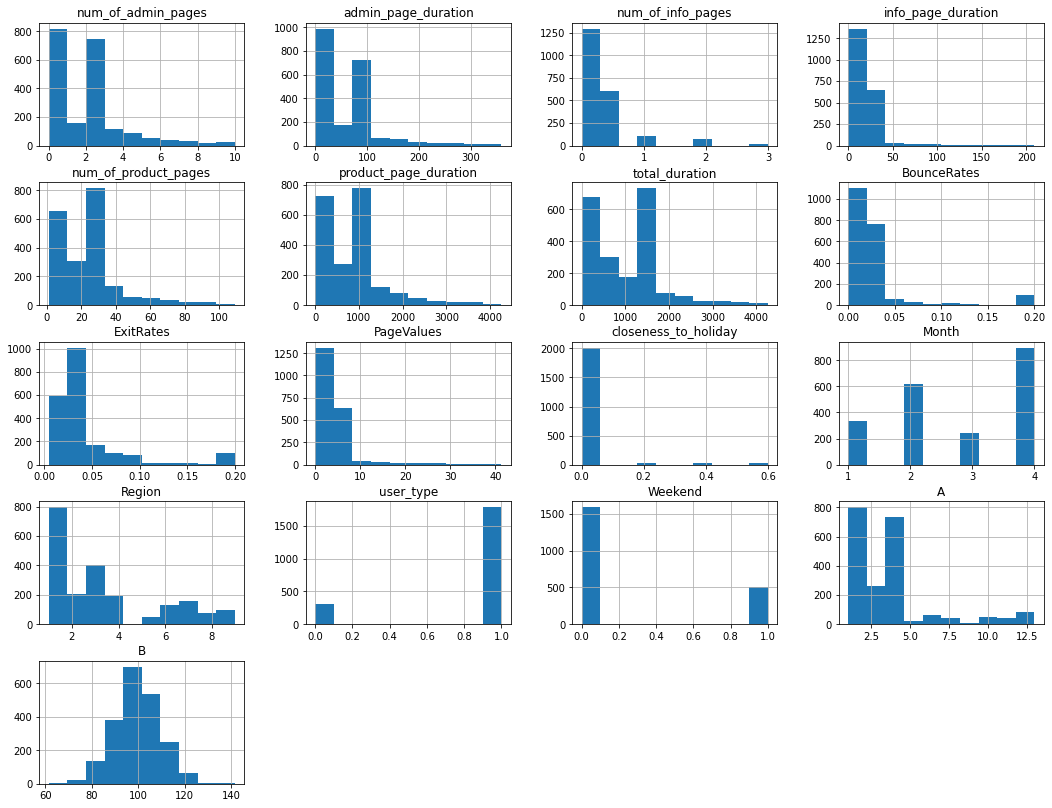

In [54]:
X_train.loc[:, ~X_train.columns.str.contains('_dmy_')].hist(figsize=(18,14))

In [55]:
des = X_train.describe()
std = des.loc[des.index == 'std']
std.iloc[:,0:20]


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,Region,user_type,Weekend,A,B,device_dmy_1,device_dmy_2,device_dmy_3
std,1.924727,60.898902,0.509948,24.509776,18.313109,742.425219,772.372792,0.043026,0.042078,5.97988,0.087706,1.154465,2.460814,0.35704,0.428399,2.784205,9.93346,0.401875,0.500065,0.404676


In [56]:
std.iloc[:,20:]


,device_dmy_other,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
std,0.277468,0.376079,0.384637,0.369242,0.359827,0.378571,0.365271,0.288596,0.47296,0.226889,0.393503


In [57]:
del std, des 

In [58]:
duration_treshold = 30
print("users who purchesed after less then 30 seconds:",
      y_train[X_train['total_duration'] < duration_treshold].sum())
print(f'number of users under {duration_treshold} seconds:',
      X_train.loc[X_train['total_duration'] < duration_treshold].shape[0])


users who purchesed after less then 30 seconds: 0
number of users under 30 seconds: 142


In [59]:
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
2442,0.000000,0.000000,0.000000,0.000000,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,...,0,0,1,0,0,0,0,1,0,0
4138,7.000000,188.166667,0.000000,0.000000,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,...,0,0,0,0,0,1,1,0,0,0
8935,2.375656,83.580020,0.492124,35.480214,32.495943,1237.523523,1359.783022,0.021192,0.041916,6.620454,...,0,0,1,0,0,0,0,1,0,0
3648,4.000000,259.000000,1.000000,42.000000,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,...,0,0,0,0,1,0,0,0,0,1
10110,1.000000,153.500000,0.000000,0.000000,26.000000,1002.847222,1156.347222,0.000000,0.009524,41.134331,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,...,0,1,0,0,0,0,1,0,0,0
9704,2.375656,83.580020,0.492124,35.480214,32.495943,1237.523523,1359.783022,0.021192,0.041916,6.620454,...,0,0,0,0,0,1,0,1,0,0
10185,0.000000,0.000000,0.000000,0.000000,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,...,0,0,0,0,0,1,0,0,0,1
9256,7.000000,104.450000,0.000000,0.000000,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,...,0,0,0,0,1,0,0,0,0,1


### standarization

In [60]:
[f for f in X_train.columns if ('_dmy_' in f)]
## needed ?

['device_dmy_1',
 'device_dmy_2',
 'device_dmy_3',
 'device_dmy_other',
 'C_dmy_100',
 'C_dmy_200',
 'C_dmy_202',
 'C_dmy_400',
 'C_dmy_404',
 'C_dmy_8080',
 'internet_browser_dmy_browser',
 'internet_browser_dmy_chrome',
 'internet_browser_dmy_edge',
 'internet_browser_dmy_safari']

In [61]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]
X_train.loc[:,~X_train.columns.isin(dummy_features + noraml_features)]

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,Region,user_type,Weekend,A
2442,0.000000,0.000000,0.000000,0.000000,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,0.000000,2.0,3.0,1,0,13.000000
4138,7.000000,188.166667,0.000000,0.000000,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,0.000000,2.0,6.0,1,1,5.000000
8935,2.375656,83.580020,0.492124,35.480214,32.495943,1237.523523,1359.783022,0.021192,0.041916,6.620454,0.059403,4.0,9.0,0,1,3.937947
3648,4.000000,259.000000,1.000000,42.000000,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,0.059403,2.0,3.0,1,0,3.000000
10110,1.000000,153.500000,0.000000,0.000000,26.000000,1002.847222,1156.347222,0.000000,0.009524,41.134331,0.000000,4.0,4.0,1,0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,0.000000,3.0,2.0,1,0,6.000000
9704,2.375656,83.580020,0.492124,35.480214,32.495943,1237.523523,1359.783022,0.021192,0.041916,6.620454,0.059403,4.0,1.0,1,0,3.937947
10185,0.000000,0.000000,0.000000,0.000000,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,0.000000,4.0,1.0,1,0,2.000000
9256,7.000000,104.450000,0.000000,0.000000,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,0.000000,4.0,8.0,1,0,2.000000


In [62]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]
scaled_features = ['closeness_to_holiday']

def features_scaling(X):
    # standard_scaler = StandardScaler()
    minmax_scalar = MinMaxScaler()
    # standard_scaler.fit(X_train.loc[:,noraml_features])
    # minmax_mask = ~X.columns.isin(dummy_features + noraml_features)
    minmax_mask = ~X.columns.isin(dummy_features + scaled_features)
    minmax_scalar.fit(X.loc[:,minmax_mask])

    # X.loc[:,noraml_features] = standard_scaler.transform(X.loc[:,noraml_features])
    X.loc[:,minmax_mask] = minmax_scalar.transform(X.loc[:,minmax_mask])

    return X 

X_train = features_scaling(X_train)
X_val = features_scaling(X_val)
X_test = features_scaling(X_test)


X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
2442,0.000000,0.000000,0.000000,0.000000,0.037037,0.025341,0.025341,0.000000,0.386364,0.000000,...,0,0,1,0,0,0,0,1,0,0
4138,0.700000,0.524141,0.000000,0.000000,0.472222,0.255674,0.299826,0.017544,0.029605,0.486527,...,0,0,0,0,0,1,1,0,0,0
8935,0.237566,0.232813,0.164041,0.169762,0.291629,0.290373,0.319060,0.105961,0.191615,0.160107,...,0,0,1,0,0,0,0,1,0,0
3648,0.400000,0.721448,0.333333,0.200957,0.157407,0.094318,0.164945,0.000000,0.064743,0.000000,...,0,0,0,0,1,0,0,0,0,1
10110,0.100000,0.427577,0.000000,0.000000,0.231481,0.235308,0.271326,0.000000,0.025974,0.994783,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.000000,0.000000,0.000000,0.000000,0.009259,0.002816,0.002816,0.000000,0.488636,0.000000,...,0,1,0,0,0,0,1,0,0,0
9704,0.237566,0.232813,0.164041,0.169762,0.291629,0.290373,0.319060,0.105961,0.191615,0.160107,...,0,0,0,0,0,1,0,1,0,0
10185,0.000000,0.000000,0.000000,0.000000,0.074074,0.209182,0.209182,0.000000,0.041193,0.000000,...,0,0,0,0,0,1,0,0,0,1
9256,0.700000,0.290947,0.000000,0.000000,0.574074,0.291578,0.316087,0.059559,0.114922,0.000000,...,0,0,0,0,1,0,0,0,0,1


In [63]:
##  check

minmax_mask = ~X_train.columns.isin(dummy_features + scaled_features)
X_train.loc[:,minmax_mask]

## needed ?

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,Month,Region,user_type,Weekend,A,B
2442,0.000000,0.000000,0.000000,0.000000,0.037037,0.025341,0.025341,0.000000,0.386364,0.000000,0.333333,0.250,1.0,0.0,1.000000,0.380877
4138,0.700000,0.524141,0.000000,0.000000,0.472222,0.255674,0.299826,0.017544,0.029605,0.486527,0.333333,0.625,1.0,1.0,0.333333,0.421998
8935,0.237566,0.232813,0.164041,0.169762,0.291629,0.290373,0.319060,0.105961,0.191615,0.160107,1.000000,1.000,0.0,1.0,0.244829,0.329839
3648,0.400000,0.721448,0.333333,0.200957,0.157407,0.094318,0.164945,0.000000,0.064743,0.000000,0.333333,0.250,1.0,0.0,0.166667,0.596423
10110,0.100000,0.427577,0.000000,0.000000,0.231481,0.235308,0.271326,0.000000,0.025974,0.994783,1.000000,0.375,1.0,0.0,0.083333,0.703634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.000000,0.000000,0.000000,0.000000,0.009259,0.002816,0.002816,0.000000,0.488636,0.000000,0.666667,0.125,1.0,0.0,0.416667,0.433263
9704,0.237566,0.232813,0.164041,0.169762,0.291629,0.290373,0.319060,0.105961,0.191615,0.160107,1.000000,0.000,1.0,0.0,0.244829,0.482548
10185,0.000000,0.000000,0.000000,0.000000,0.074074,0.209182,0.209182,0.000000,0.041193,0.000000,1.000000,0.000,1.0,0.0,0.083333,0.262463
9256,0.700000,0.290947,0.000000,0.000000,0.574074,0.291578,0.316087,0.059559,0.114922,0.000000,1.000000,0.875,1.0,0.0,0.083333,0.436705


In [64]:
def validate_data_prep(X):
    print(X.isna().sum().max() == 0)
    print(np.all(X_train.max() <= 1))
    print(np.all(X_train.min() >= 0))

print('check train data:')
validate_data_prep(X_train)
print('check validation data:')
validate_data_prep(X_val)
print('check test data:')
validate_data_prep(X_test)

check train data:
True
True
True
check validation data:
True
True
True
check test data:
True
True
True


# dimensionality reduction

### PCA

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, whiten=True)
pca.fit(X_train)
X_val_reduced = pca.transform(X_val)
X_train_reduced = pca.transform(X_train)

In [34]:
X_val_pca = pca.inverse_transform(X_val_reduced)
X_train_pca = pca.inverse_transform(X_train_reduced)
del X_val_reduced, X_train_reduced

# Models !

## generic kfold validation function

In [104]:
from types import FunctionType

def validate_model(all_data, all_labels, model, model_name, num_folds=10):
    """validates model using auc on k-fold cross validation"""
    # 0.5 auc line
    baseline = [0,1]
    plt.plot(baseline, baseline, color='black', linestyle=':')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    


    # fpr would be the x axis. this is to calc mean auc between all iterations
    fpr_all_values = np.linspace(0,1,100) 
    tpr_sum = np.array([0.0]*100) 
    auc_sum = 0

    for train_mask, val_mask in KFold(num_folds, shuffle=True, random_state=13).split(X=all_data, y=all_labels):
        xt = all_data.iloc[train_mask] # x train
        xv = all_data.iloc[val_mask] # x validation
        yt = all_labels.iloc[train_mask] # y train
        yv = all_labels.iloc[val_mask] # y validation
        
        model.fit(xt, yt)

        fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(xv)[:,1])
        plt.plot(fpr, tpr, color='lightpink')
        tpr_sum += np.interp(fpr_all_values, fpr, tpr)
        auc_sum += roc_auc_score(yv, model.predict_proba(xv)[:,1])
            

    plt.plot(fpr_all_values, tpr_sum / num_folds , color='darkred')
    plt.title(f'{model_name} result. AUC={round(auc_sum / num_folds, 5)}')
    


def auc_score(model, xv, yv):
    return max(
            roc_auc_score(yv, model.predict_proba(xv)[:,i])
            for i in (0,1))

def accuracy_score(model,xv,yv):
    return model.score(xv, yv)

def plot_scores(model_class, arg_name:str, arg_values:list,
            other_args:dict = None, xt=X_train, xv=X_val,
            yt=y_train, yv=y_val, tuple_index=None,
            scoring:FunctionType = auc_score, plot_type='plot'):
    """ for example :  
            plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
                        other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')"""
    print(f'calculating and plotting scores for {model_class.__name__}:')
    multiplot = False
    d = other_args or {} 
    scores = []
    best = 0
    for i, value in enumerate(arg_values):
        print(f'progress: [{int((i / len(arg_values)) * 100)}%]\r', end='')
        d[arg_name] = value
        model = model_class(**d)
        model.fit(xt, yt)
        if not hasattr(scoring, '__iter__'):
            scores.append(scoring(model, xv, yv))
        else:
            multiplot = True
            current_scores = []
            for score in scoring:
                current_scores.append(score(model,xv,yv))
            scores.append(current_scores)
    
   
    values = None
    # spaciel case for nural networks
    if type(tuple_index) is int:
        values = [i[tuple_index] for i in arg_values]
    elif type(tuple_index) is str:
        values = [float(i[1]) + i[0] / 100 for i in arg_values] 
    else:
        values = arg_values      


    # plotting
    if multiplot:
        figure, axes = plt.subplots(1,len(scoring))
        figure.set_size_inches((12,4))
        func_name_prefix = 'set_'
        scores = np.array(scores).T
        best_is = scores.argmax(axis=1)
        bests = [(arg_values[best_index], scores[score_idnex][best_index]) for score_idnex, best_index in enumerate(best_is)]
        best = bests[0] # auc score
    else:
        best_i = np.argmax(scores)
        best = arg_values[best_i], scores[best_i] 
        bests= [best]
        axes = [plt]
        scoring = [scoring]
        func_name_prefix = ''
        scores = [scores]

    for i,axe in enumerate(axes):
        axe.__getattribute__(plot_type)(
            values, scores[i], label=f'best {arg_name}: {bests[i][0]}, best score: {round(bests[i][1],5)}')
        axe.__getattribute__ (func_name_prefix+'ylabel')(scoring[i].__name__)
        axe.__getattribute__ (func_name_prefix+'xlabel')(arg_name)
        axe.__getattribute__(func_name_prefix+'title')(f'{scoring[i].__name__} for {model_class.__name__}')
        axe.legend()
        
    return best


def plot_confusion_matrix(labels,preds):
    #Create the confusion matrix:
    cm = confusion_matrix(labels,preds)
    tn,fp,fn,tp = cm.ravel()
    cm = np.array([[tp,fp],[fn,tn]])

    # Plot the confusion matrix:
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    


### combine all data for k-fold

In [ ]:
all_data = pd.concat([X_train, X_val])
all_label = pd.concat([y_train, y_val])

## logistic regression

### 1. running LR with no class weights.  
checking various c values

### note: **we didnt use this configuration**

calculating and plotting scores for LogisticRegression:


(10, 0.8071174761239354)

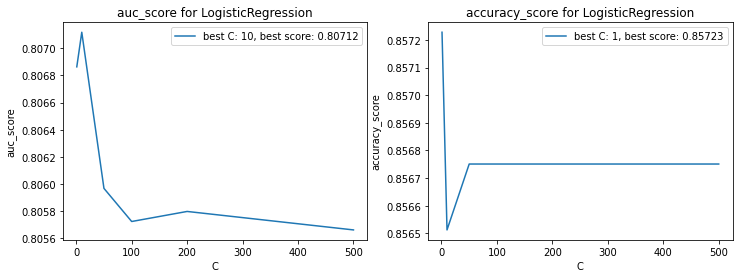

In [105]:
Cs = [1,10,50,100,200,500]
args = {
     "penalty":"l2", "dual":False, "tol":0.0001, "C":1, "fit_intercept":True,
      "intercept_scaling":1, "class_weight":None, "random_state":None, "solver":"lbfgs",
      "max_iter":100, "multi_class":"auto", "verbose":0, "warm_start":False, "n_jobs":None, "l1_ratio":None}


plot_scores(model_class=LogisticRegression, arg_name='C', arg_values=Cs, other_args=args, scoring=(auc_score, accuracy_score))



### 2. trying to use solver `saga` had very little affect.
### note: **we didnt use this configuration**

calculating and plotting scores for LogisticRegression:


(10, 0.8071700132759857)

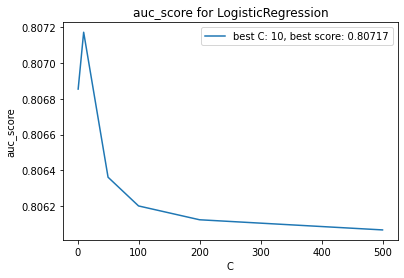

In [113]:
Cs = [1,10,50,100,200,500]
args = {
     "penalty":"l2", "dual":False, "tol":0.0001, "C":1, "fit_intercept":True,
      "intercept_scaling":1, "class_weight":None, "random_state":None, "solver":"saga",
      "max_iter":100, "multi_class":"auto", "verbose":0, "warm_start":False, "n_jobs":None, "l1_ratio":None}
plot_scores(model_class=LogisticRegression, arg_name='C', arg_values=Cs, other_args=args, )



### 3. use class weighets
setting paramert `class_weight` to `balanced` tells the model to take into account y distribution in X_train.
as shown below, this provides us a with an improvment from 0.80 auc to 0.82 auc.   


calculating and plotting scores for LogisticRegression:


(50, 0.8263424768324239)

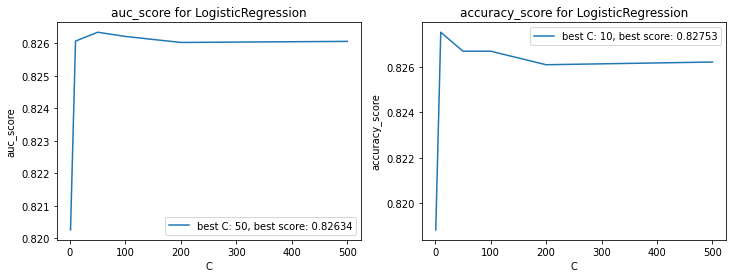

In [108]:
Cs = [1,10,50,100,200,500]
args = {
     "penalty":"l2", "dual":False, "tol":0.0001, "C":1, "fit_intercept":True,
      "intercept_scaling":1, "class_weight":'balanced', "random_state":None, "solver":"lbfgs",
      "max_iter":100, "multi_class":"auto", "verbose":0, "warm_start":False, "n_jobs":None, "l1_ratio":None}
plot_scores(model_class=LogisticRegression, arg_name='C', arg_values=Cs, other_args=args,scoring=(auc_score, accuracy_score))



### 3.1 finding best c.
best auc is for c=50, best accuracy is for c=10. let's check range 5 to 80

calculating and plotting scores for LogisticRegression:


(30, 0.8264440631928202)

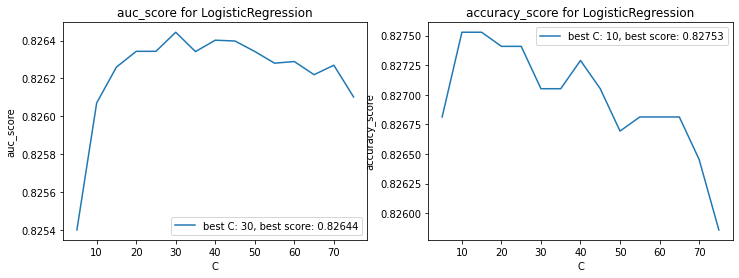

In [109]:
Cs = [i for i in range(5,80,5)]
args = {
     "penalty":"l2", "dual":False, "tol":0.0001, "C":1, "fit_intercept":True,
      "intercept_scaling":1, "class_weight":'balanced', "random_state":None, "solver":"lbfgs",
      "max_iter":100, "multi_class":"auto", "verbose":0, "warm_start":False, "n_jobs":None, "l1_ratio":None}
plot_scores(model_class=LogisticRegression, arg_name='C', arg_values=Cs, other_args=args,scoring=(auc_score, accuracy_score))


### best Conifuration: **c=30 class_weight=balanced**
when zooming in to 25-45 range. seems accuracy and auc agrees on smaller range.

### *however, this is not the chosen model.*

calculating and plotting scores for LogisticRegression:


(30, 0.8264440631928202)

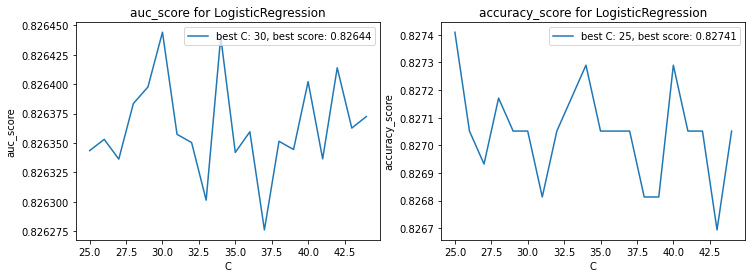

In [111]:
Cs = [i for i in range(25,45,1)]
args = {
     "penalty":"l2", "dual":False, "tol":0.0001, "C":1, "fit_intercept":True,
      "intercept_scaling":1, "class_weight":'balanced', "random_state":None, "solver":"lbfgs",
      "max_iter":100, "multi_class":"auto", "verbose":0, "warm_start":False, "n_jobs":None, "l1_ratio":None}
plot_scores(model_class=LogisticRegression, arg_name='C', arg_values=Cs,
             other_args=args,scoring=(auc_score, accuracy_score))


### K-fold validation on chosen LR configuration:



## K-nn 
 

### when chcking kn in the range of 1-80, best auc is 063, which is very low:

In [ ]:

ns = [n for n in range(1,80,5)]
args = {"n_neighbors":5, "weights":'uniform', "algorithm":'auto', "leaf_size":30, "p":2,
        "metric": 'minkowski', "metric_params": None, "n_jobs": None}


plot_scores(model_class=KNeighborsClassifier, arg_name="n_neighbors",
            arg_values=ns, other_args=args, scoring=(auc_score, accuracy_score))




### try using PCA version of the data has no improvment:

calculating and plotting scores for KNeighborsClassifier:


(56, 0.6371531948474352)

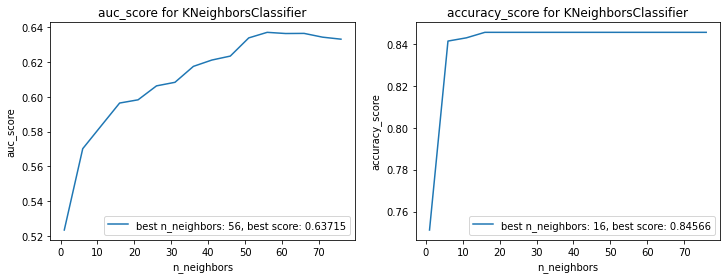

In [9]:

ns = [n for n in range(40,60,2)]
args = {"n_neighbors":5, "weights":'uniform', "algorithm":'auto', "leaf_size":30, "p":2,
        "metric": 'minkowski', "metric_params": None, "n_jobs": None}


plot_scores(model_class=KNeighborsClassifier, arg_name="n_neighbors",
            arg_values=ns, other_args=args, scoring=(auc_score, accuracy_score),xt=X_train_pca)




### setting weights to `distance`. which mean the distance between points is considered.
closer neighubers influence more that far away ones
this helped a little, but doesnt seem signifigant

calculating and plotting scores for KNeighborsClassifier:


(56, 0.6415091460423828)

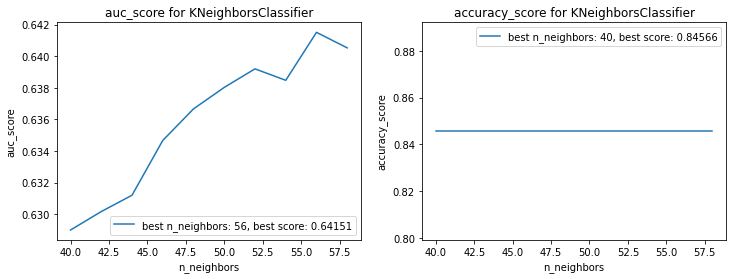

In [11]:

ns = [n for n in range(40,60,2)]
args = {"n_neighbors":5, "weights":'distance', "algorithm":'auto', "leaf_size":30, "p":2,
        "metric": 'minkowski', "metric_params": None, "n_jobs": None}


plot_scores(model_class=KNeighborsClassifier, arg_name="n_neighbors",
            arg_values=ns, other_args=args, scoring=(auc_score, accuracy_score))




### KNN results are very poor. 
### This is not the chosen model.

seems the right number of neighbors would be around []. we'll let `GridSearch` decide the exact value

In [ ]:
ns = [i for i in range(15,40,1)]
cross_valudation = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=50, ), param_grid={'n_neighbors': ns}, scoring='roc_auc')
cross_valudation.fit(all_data, all_label)
best_n = cross_valudation.best_estimator_.n_neighbors

print("chosen number of neighbors:", best_n)
model = KNeighborsClassifier(n_neighbors=best_n)



In [ ]:
validate_model(all_data, all_label, model, 'KNN')

the mean of a 340 cluster giver 0.67 auc

## Multi-Layer Perceptron

in order to quicly get a direction of correct network architecture, we will set max_iter to 70.
and use grid search to find best parameters

In [7]:
import warnings
warnings.filterwarnings('ignore')

model = MLPClassifier(activation='relu',
             solver='adam', batch_size='auto', power_t=0.5, max_iter=50, shuffle=True, random_state=None,
             tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
             validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

hidden_layers_values = []
for d1 in range(20,200,50):
        for d2 in range(1,10,3):
            hidden_layers_values.append((d1,d2))

params = {
    "hidden_layer_sizes":hidden_layers_values,
    "alpha": [10**i for i in range(-3,2)],
    "learning_rate_init": [10**i for i in range(-3,2)],
    "learning_rate": ('constant', 'adaptive')
}

grid = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_




In [ ]:
degrees = [1,2,4,6,8,30,50,70,120]
args = {"C":2, "kernel":"rbf", "gamma":"scale", "coef0":0, "shrinking":True, "probability":True, "tol":0.001,
"cache_size":200, "class_weight":None, "verbose":False, "max_iter":-1, "decision_function_shape":"ovr", "break_ties":False, "random_state":None}

plot_scores(model_class=svm.SVC, arg_name='degree', other_args=args, arg_values=degrees, scoring=(auc_score, accuracy_score))

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(25,10), max_iter=100, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=1,
                         alpha=0.01, learning_rate='adaptive')

model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':100, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(50,300,15):
        for d2 in range(2,15,2):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

model.fit(X_train, y_train)
plot_scores(MLPClassifier,'hidden_layer_sizes', hidden_layers_values, args, 
X_train, X_val, y_train, y_val, 'both')



closer look into 14 layers of 185 neurons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':100, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(170,190,1):
        for d2 in range(10,15,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(MLPClassifier,'hidden_layer_sizes', hidden_layers_values, args, 
X_train, X_val, y_train, y_val, 'both', scoring)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':500, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(165,175,1):
        for d2 in range(12,15,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')

In [ ]:
warnings.filterwarnings('default')

model = MLPClassifier(hidden_layer_sizes=(170,13), max_iter=200, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=1, alpha=0.01, learning_rate='adaptive')

model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


2
calculating and plotting scores for MLPClassifier:
DONE. best score:((165, 13), 0.8456583969465649) achived by: ((165, 13), 0.5)


[((165, 13), 0.5), ((165, 13), 0.8456583969465649)]

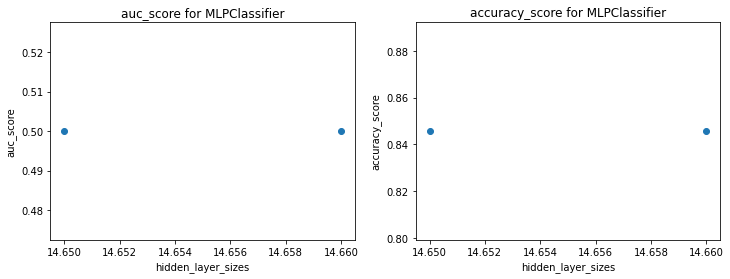

In [ ]:
import warnings
warnings.filterwarnings('ignore')

args = {'max_iter':20, 'solver':'sgd','verbose':False,
        'tol':10**-6,'random_state':13, 'learning_rate_init':1,
        'learning_rate':'adaptive', 'alpha':0.01, }
hidden_layers_values = []
for d1 in range(165,167,1):
        for d2 in range(13,14,1):
                hidden_layers_values.append((d1,d2))
print(len(hidden_layers_values))

scoring = (auc_score, accuracy_score)
plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')

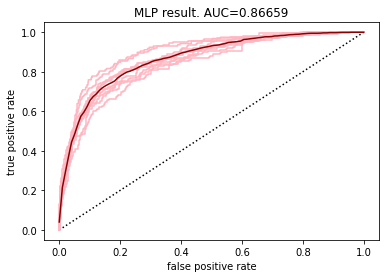

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(165,13), max_iter=250, solver='sgd',
                        tol=10**-6,random_state=12, learning_rate_init=0.1, alpha=0.01, learning_rate='adaptive')
validate_model(all_data, all_label, model, 'MLP')

## Support Vecor Machines

In [32]:
from sklearn import svm
model = svm.SVC(C=2, probability=True)
model.fit(X_train_pca, y_train)
roc_auc_score(y_val, model.predict_proba(X_val_pca)[:,1])

0.8148320991099205

In [18]:
cs = [1,2,4,6,8,30,50,70,120]
args = {"kernel":"rbf", "gamma":"scale", "coef0":0, "shrinking":True, "probability":True, "tol":0.001,
"cache_size":200, "class_weight":None, "verbose":False, "max_iter":-1, "decision_function_shape":"ovr", "break_ties":False, "random_state":None}

plot_scores(model_class=svm.SVC, arg_name='C', other_args=args, arg_values=cs, scoring=(auc_score, accuracy_score))

calculating and plotting scores for SVC:


(70, 0.8109070179607301)

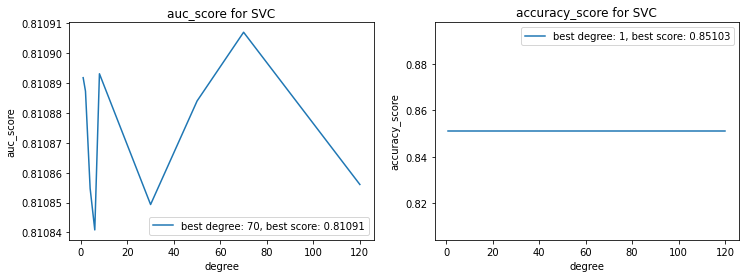

In [21]:
degrees = [1,2,4,6,8,30,50,70,120]
args = {"C":2, "kernel":"rbf", "gamma":"scale", "coef0":0, "shrinking":True, "probability":True, "tol":0.001,
"cache_size":200, "class_weight":None, "verbose":False, "max_iter":-1, "decision_function_shape":"ovr", "break_ties":False, "random_state":None}

plot_scores(model_class=svm.SVC, arg_name='degree', other_args=args, arg_values=degrees, scoring=(auc_score, accuracy_score))

## Ada Boost Tree

In [ ]:
model = AdaBoostClassifier(n_estimators=10)
model.fit(X_train, y_train)
auc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
print(auc)
accuracy_score(model, X_val, y_val)

calculating and plotting scores for AdaBoostClassifier:
DONE. best score:(25, 0.8901479007633588) achived by: (19, 0.9059117920836759)


[(19, 0.9059117920836759), (25, 0.8901479007633588)]

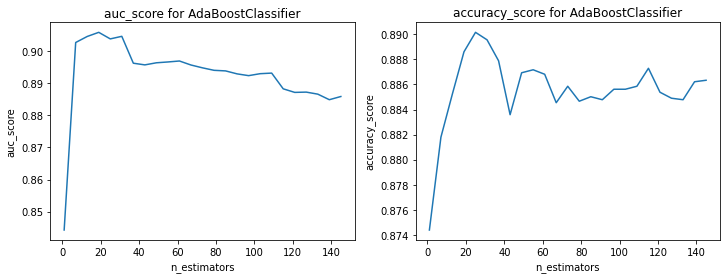

In [ ]:
scoring = (auc_score, accuracy_score)



plot_scores(model_class=AdaBoostClassifier, arg_name='n_estimators',arg_values=[i for i in range(1,150,6)], scoring=scoring)

let's zoom in to the range 5-15

calculating and plotting scores for AdaBoostClassifier:
DONE. best score:(55, 0.8655772900763359) achived by: (55, 0.8138515509359678)


[(55, 0.8138515509359678), (55, 0.8655772900763359)]

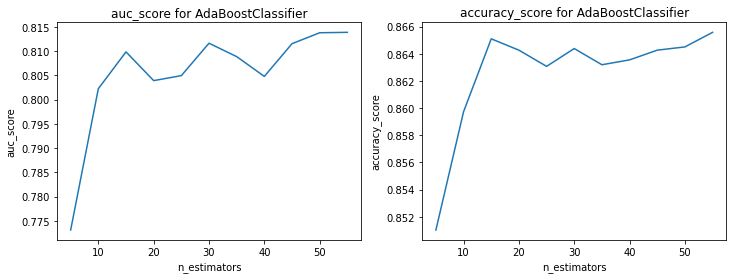

In [ ]:
scoring = (auc_score, accuracy_score)

plot_scores(model_class=AdaBoostClassifier, arg_name='n_estimators',arg_values=[i for i in range(5,60,5)], scoring=scoring,
xt=X_train_pca, xv=X_val_pca)

calculating and plotting scores for AdaBoostClassifier:
DONE. best score:(12, 0.8916984732824428) achived by: (8, 0.9047936336307533)


[(8, 0.9047936336307533), (12, 0.8916984732824428)]

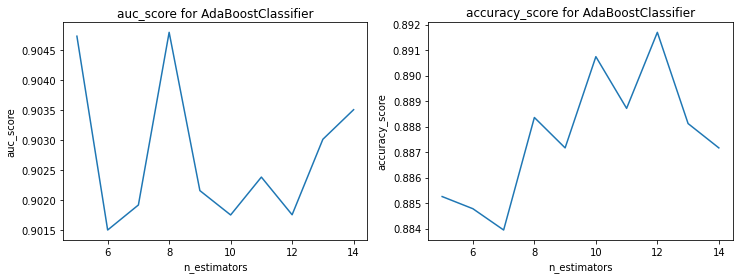

In [ ]:
scoring = (auc_score, accuracy_score)

plot_scores(model_class=AdaBoostClassifier, arg_name='n_estimators',arg_values=[i for i in range(5,15,1)], scoring=scoring)

chosen: 8

# chosen model evaluation

0.9047936336307533

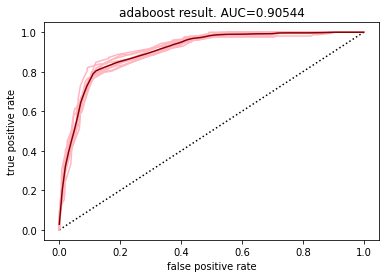

In [ ]:
all_data  = pd.concat([X_train, X_val])
all_label  = pd.concat([y_train, y_val])
validate_model(all_data, all_label, AdaBoostClassifier(n_estimators=8),'adaboost')


## confusion matrix

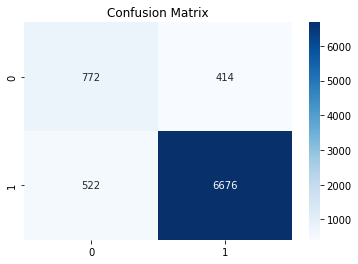

0.9047936336307533

In [ ]:
model = AdaBoostClassifier(n_estimators=8)
model.fit(X_train, y_train)
preds = model.predict(X_val)
plot_confusion_matrix(y_val, preds)
auc_score(model, X_val, y_val)

### compare train to validation

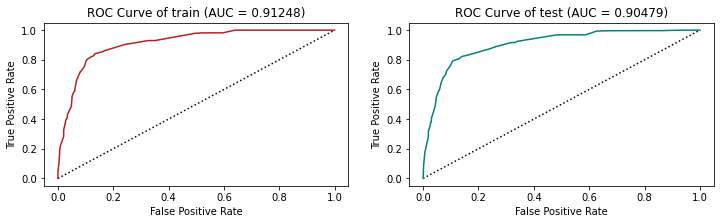

In [ ]:
def plot_roc_curves(fprs, tprs, aucs, titels, colors):
    figure, axes = plt.subplots(1,2)
    figure.set_size_inches((12,3))
    for axe, fpr, tpr, auc, title, color in zip(axes, fprs, tprs, aucs, titels, colors):
        baseline = [0,1]
        axe.plot(baseline, baseline, color='black', linestyle=':')
        axe.plot(fpr,tpr,color=color, label=title)
        axe.set_xlabel('False Positive Rate')
        axe.set_ylabel('True Positive Rate')
        axe.set_title(f'ROC Curve of {title} (AUC = {round(auc,5)})')
    plt.show()        

fpr1, tpr1, trsh = roc_curve(y_train, model.predict_proba(X_train)[:,1])
auc1 = auc_score(model, X_train, y_train)

fpr2, tpr2, trsh = roc_curve(y_val, model.predict_proba(X_val)[:,1])
auc2 = auc_score(model, X_val, y_val)

plot_roc_curves([fpr1, fpr2], [tpr1, tpr2], [auc1,auc2], ['train', 'validation'], ['firebrick', 'teal'])

## כאן זה צריך להיות טסט או ולידיישן ???? בשורה הכי אחרונה פהה שרשום טריין ואז טסט


### We can see that the train and validation AUC are simillar, what means low overfitting.

## Feature importance


In [ ]:
sorted_idx = np.argsort(model.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.rcParams["figure.figsize"] = (15,8)
plt.bar(pos, model.feature_importances_[sorted_idx], align='center')
plt.xticks(pos, np.array(all_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

## Prediction on Test Data

In [ ]:

predictions = pd.DataFrame(data = model.predict_proba(X_test)[:,1])
pd.join(predictions,)
predictions.rename(columns = {0:'predict_prob'}).to_csv("Submission_group_24.csv",index = True,index_label='id')

# Full Pipeline


In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
def id_prep(X, X_t):
    X = X.set_index('id')
    return X


def d_data_prep(X, X_t):
    return X.drop(columns=('D'))

def page_durations_prep(X, X_t):
    global avgs
    fields = ['info_page_duration', 'product_page_duration']
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page = (None, None, None)


def page_durations_fill_na(X, X_t):
    global avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page
    avg_time_in_admin_page = (X_t.admin_page_duration / X_t.num_of_admin_pages).mean()
    avg_time_in_info_page = (X_t.info_page_duration / X_t.num_of_info_pages).mean()
    avg_time_in_product_page = (X_t.product_page_duration / X_t.num_of_product_pages).mean()

    avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(duration_fields):        
        num_of_field_copy = X[num_of_fields[i]].copy()
        num_of_field_copy = num_of_field_copy.fillna(num_of_field_copy.mean())
        X.loc[X[field].isna(), field] = avgs[i] * num_of_field_copy.loc[X[field].isna()]
    return X    

def total_druation_data_prep(X, X_t):
    computed_durations = X.admin_page_duration + X.info_page_duration + X.product_page_duration
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

def num_of_visits_data_prep(X: pd.DataFrame, X_t):
    global avg_time_in_admin_page, avg_time_in_info_page, avg_time_in_product_page
    avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)
    duration_fields = ('info_page_duration', 'product_page_duration', 'admin_page_duration')
    num_of_fields = ('num_of_info_pages', 'num_of_product_pages','num_of_admin_pages')
    for i, field in enumerate(num_of_fields):
        X.loc[X[field].isna(), field] = [ int(value / avgs[i]) for value in X.loc[X[field].isna(), duration_fields[i]]]
    return X


def rates_page_value_data_prep(X, X_t):    
    # so little nan values - lets fill with mean
    X.BounceRates = X.BounceRates.fillna(X_t.BounceRates.mean())
    X.ExitRates = X.ExitRates.fillna(X_t.ExitRates.mean())
    X.PageValues = X.PageValues.fillna(X_t.PageValues.mean())
    return X

def user_type_data_prep(X, X_t):
    RETURNING ='Returning_Visitor'
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

def closeness_data_prep(X, X_t):    
    X.closeness_to_holiday = X.closeness_to_holiday.fillna(X_t.closeness_to_holiday.mean())
    return X

def make_dummy_C(X: pd.DataFrame, X_t):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False, prefix_sep='_dmy_')

def weekend_data_prep(X, X_t):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

def b_data_prep(X, X_t):    
    X.B = X.B.fillna(X_t.B.mean())
    return X

def make_dummy_device(X: pd.DataFrame, X_t):
    mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False, prefix_sep='_dmy_')
    

def browser_data_prep(X: pd.DataFrame, X_t):    
    X.internet_browser = X.internet_browser.str.replace('\d+', '')
    X['internet_browser'] = X['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')    
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')    


    # device 1 means safari
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_1 > 0), ('internet_browser_dmy_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_2 + X.device_dmy_3  > 0), ('internet_browser_dmy_chrome',)] = 1

    print(X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1), 'internet_browser_dmy_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_dmy_nan == 1) & ((X.internet_browser_dmy_chrome + X.internet_browser_dmy_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_dmy_nan'])

def month_data_prep(X, X_t):
     Month_map = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
     X.Month = X.Month.map(Month_map)
     X.Month = X.Month.fillna(X_t.Month.median())
     return X

def region_data_prep(X: pd.DataFrame, X_t):
    train_median = np.median(X_t.Region[~X_t.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X

def a_data_prep(X,X_t):
    X.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X.A]
    X.A = X.A.fillna(X_t.A.median())
    #X.A[X.A.isnull()] = train_median
    return X

def outlier_removal(X, X_t):
    column_mask = (~X.columns.str.contains('_dmy_') & ~X.columns.isin(['user_type', 'Weekend', 'Month', 'B']))
    max_trashold = X.loc[:,column_mask].quantile(q=0.95)
    min_trashold = X.loc[:,column_mask].quantile(q=0.05)

    no_outliers =  X.loc[:,column_mask]

    outlier_mask = ((no_outliers < min_trashold) | (no_outliers > max_trashold)).any(axis=1)

    mean = X_t.loc[:,column_mask].mean(axis=0).values.reshape(1,column_mask.sum())

    X.loc[outlier_mask,column_mask] = mean
    return X

def features_scaling(X, X_t):    
    dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]

    minmax_scalar = MinMaxScaler()    
    minmax_mask = ~X.columns.isin(dummy_features)
    minmax_scalar.fit(X.loc[:,minmax_mask])
    X.loc[:,minmax_mask] = minmax_scalar.transform(X.loc[:,minmax_mask])

    return X 

In [3]:
save_print_func = print
data_prep_functions = [
    id_prep,d_data_prep, page_durations_prep, page_durations_fill_na, total_druation_data_prep, 
    num_of_visits_data_prep, rates_page_value_data_prep, user_type_data_prep ,closeness_data_prep, make_dummy_C,
    weekend_data_prep, b_data_prep,make_dummy_device, browser_data_prep, month_data_prep, region_data_prep, a_data_prep,
    # outlier_removal,
     features_scaling
]



def silent_print(*args, **kwargs):
    return
    

print = silent_print


data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
id_test = X_test.id

Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]
X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.8,random_state=23)

for prep in data_prep_functions:
    X_train = prep(X_train, X_train)
    X_val = prep(X_val, X_train)
    X_test = prep(X_test, X_train)

all_data  = pd.concat([X_train, X_val])
all_label  = pd.concat([y_train, y_val])

print = save_print_func



In [4]:


def validate_data_prep(X):
    print(X.isna().sum().max() == 0)
    print(np.all(X.max() <= 1.01))
    print(np.all(X.min() >= -0.01))

validate_data_prep(X_train)
validate_data_prep(X_val)
validate_data_prep(X_test)



True
True
True
True
True
True
True
True
True


In [5]:
from types import FunctionType

def validate_model(all_data, all_labels, model, model_name, num_folds=10):
    """validates model using auc on k-fold cross validation"""
    # 0.5 auc line
    baseline = [0,1]
    plt.plot(baseline, baseline, color='black', linestyle=':')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    


    # fpr would be the x axis. this is to calc mean auc between all iterations
    fpr_all_values = np.linspace(0,1,100) 
    tpr_sum = np.array([0.0]*100) 
    auc_sum = 0

    for train_mask, val_mask in KFold(num_folds, shuffle=True, random_state=13).split(X=all_data, y=all_labels):
        xt = all_data.iloc[train_mask] # x train
        xv = all_data.iloc[val_mask] # x validation
        yt = all_labels.iloc[train_mask] # y train
        yv = all_labels.iloc[val_mask] # y validation
        
        model.fit(xt, yt)

        fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(xv)[:,1])
        plt.plot(fpr, tpr, color='lightpink')
        tpr_sum += np.interp(fpr_all_values, fpr, tpr)
        auc_sum += roc_auc_score(yv, model.predict_proba(xv)[:,1])
            

    plt.plot(fpr_all_values, tpr_sum / num_folds , color='darkred')
    plt.title(f'{model_name} result. AUC={round(auc_sum / num_folds, 5)}')
    


def auc_score(model, xv, yv):
    return max(
            roc_auc_score(yv, model.predict_proba(xv)[:,i])
            for i in (0,1))

def accuracy_score(model,xv,yv):
    return model.score(xv, yv)

def plot_scores(model_class, arg_name:str, arg_values:list,
            other_args:dict = None, xt=X_train, xv=X_val,
            yt=y_train, yv=y_val, tuple_index=None,
            scoring:FunctionType = auc_score, plot_type='plot'):
    """ for example :  
            plot_scores(model_class=MLPClassifier,arg_name='hidden_layer_sizes', arg_values=hidden_layers_values,
                        other_args=args, xt=X_train, xv=X_val, yt=y_train, yv=y_val, tuple_index='both', scoring=scoring,plot_type='scatter')"""
    print(f'calculating and plotting scores for {model_class.__name__}:')
    multiplot = False
    d = other_args or {} 
    scores = []
    best = 0
    for i, value in enumerate(arg_values):
        print(f'progress: [{int((i / len(arg_values)) * 100)}%]\r', end='')
        d[arg_name] = value
        model = model_class(**d)
        model.fit(xt, yt)
        if not hasattr(scoring, '__iter__'):
            scores.append(scoring(model, xv, yv))
        else:
            multiplot = True
            current_scores = []
            for score in scoring:
                current_scores.append(score(model,xv,yv))
            scores.append(current_scores)
    
   
    values = None
    # spaciel case for nural networks
    if type(tuple_index) is int:
        values = [i[tuple_index] for i in arg_values]
    elif type(tuple_index) is str:
        values = [float(i[1]) + i[0] / 100 for i in arg_values] 
    else:
        values = arg_values      


    # plotting
    if multiplot:
        figure, axes = plt.subplots(1,len(scoring))
        figure.set_size_inches((12,4))
        func_name_prefix = 'set_'
        scores = np.array(scores).T
        best_is = scores.argmax(axis=1)
        bests = [(arg_values[best_index], scores[score_idnex][best_index]) for score_idnex, best_index in enumerate(best_is)]
        best = bests[0] # auc score
    else:
        best_i = np.argmax(scores)
        best = arg_values[best_i], scores[best_i] 
        bests= [best]
        axes = [plt]
        scoring = [scoring]
        func_name_prefix = ''
        scores = [scores]

    for i,axe in enumerate(axes):
        axe.__getattribute__(plot_type)(
            values, scores[i], label=f'best {arg_name}: {bests[i][0]}, best score: {round(bests[i][1],5)}')
        axe.__getattribute__ (func_name_prefix+'ylabel')(scoring[i].__name__)
        axe.__getattribute__ (func_name_prefix+'xlabel')(arg_name)
        axe.__getattribute__(func_name_prefix+'title')(f'{scoring[i].__name__} for {model_class.__name__}')
        axe.legend()
        
    return best


def plot_confusion_matrix(labels,preds):
    #Create the confusion matrix:
    cm = confusion_matrix(labels,preds)
    tn,fp,fn,tp = cm.ravel()
    cm = np.array([[tp,fp],[fn,tn]])

    # Plot the confusion matrix:
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    
